In [1]:
#Import the libraries
import pandas as pd 
import numpy as np 
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from pathlib import Path
import numpy as np 
import matplotlib

In [2]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [3]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [4]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [5]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [6]:
# Select SS316 stainless steel and sub-sized data
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [7]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [8]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [9]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [10]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [11]:
# Drop the columns that don't have  enough data records. 

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment',  'Specimen Size Type',
                                       'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Uniform Elongation (%)',
                                       'Yield Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [12]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 21 to 907
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Material Group                   209 non-null    object 
 1   C (wt.%)                         209 non-null    float64
 2   Si (wt.%)                        209 non-null    float64
 3   Mn (wt.%)                        209 non-null    float64
 4   P (wt.%)                         209 non-null    float64
 5   S (wt.%)                         209 non-null    float64
 6   Ni (wt.%)                        209 non-null    float64
 7   Cr (wt.%)                        209 non-null    float64
 8   Mo (wt.%)                        209 non-null    float64
 9   Al (wt.%)                        209 non-null    float64
 10  N (wt.%)                         209 non-null    float64
 11  Ti (wt.%)                        209 non-null    float64
 12  Fe (wt.%)                 

In [13]:
# sort the dataframe by UTS values
tensile_df = tensile_df.sort_values(by='Ultimate Tensile Strength (MPa)').reset_index(drop=True)


In [14]:
# Select columns for modeling. 

input_features_df =  tensile_df.drop(columns=['Ultimate Tensile Strength (MPa)'])

In [15]:
# Encode the categorical columns 
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [16]:
# make sure input features are float data type
input_features_df = input_features_df.astype('float')

In [17]:
# define input features and input targets variables
features = input_features_df
targets = tensile_df['Ultimate Tensile Strength (MPa)']

In [18]:
# define the confidence interval
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

q: 0.025 | pearsonr: 0.7877030144491577
q: 0.5 | pearsonr: 0.9332315334834328
q: 0.975 | pearsonr: 0.5951741220896277
Pearson CC: 0.9332315334834328
R2 score: 0.868582196055622
RMSE: 55.702424989679166
MAE: 32.16664646578928
Coverage: 85.71428571428572
Interval Width: 319.12591184354267
Composite Metric: 0.6436405327064841


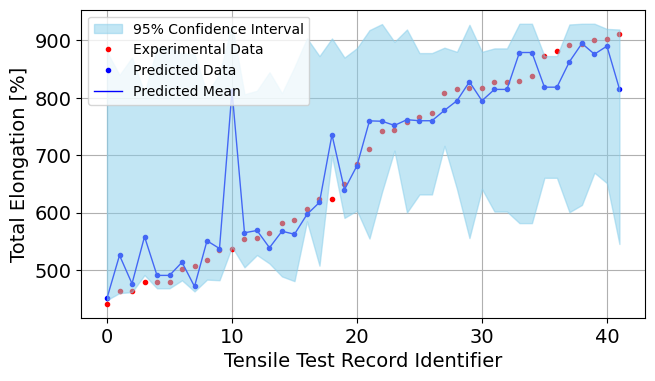

********************
q: 0.025 | pearsonr: 0.7142069416145063
q: 0.5 | pearsonr: 0.9713921202198517
q: 0.975 | pearsonr: 0.8378934834395471
Pearson CC: 0.9713921202198517
R2 score: 0.9380921998024734
RMSE: 29.471507803300447
MAE: 20.429534904910465
Coverage: 90.47619047619048
Interval Width: 241.0162066266865
Composite Metric: 0.6796087032157317


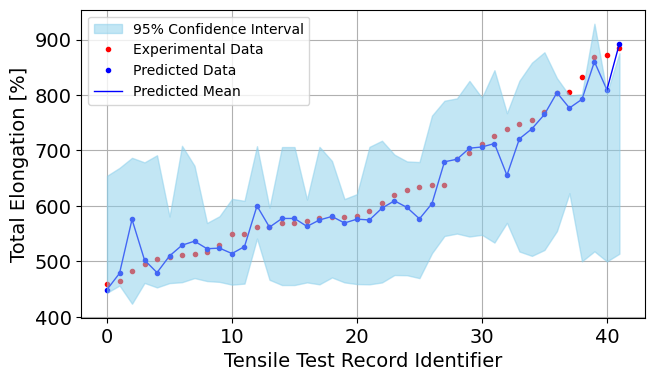

********************
q: 0.025 | pearsonr: 0.7991003156136338
q: 0.5 | pearsonr: 0.9077290889800264
q: 0.975 | pearsonr: 0.7935089175490275
Pearson CC: 0.9077290889800264
R2 score: 0.8200936860441987
RMSE: 60.437164685558656
MAE: 34.54680161419488
Coverage: 88.0952380952381
Interval Width: 264.83708405466854
Composite Metric: 0.6616582622759232


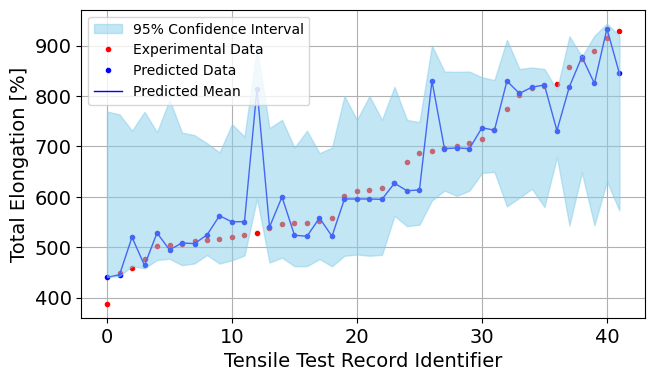

********************
q: 0.025 | pearsonr: 0.6807119823878326
q: 0.5 | pearsonr: 0.8216298557987908
q: 0.975 | pearsonr: 0.7691449588673809
Pearson CC: 0.8216298557987908
R2 score: 0.6532526203979955
RMSE: 77.37932441406832
MAE: 45.34301154426329
Coverage: 78.57142857142858
Interval Width: 196.22233976792413
Composite Metric: 0.590559779207658


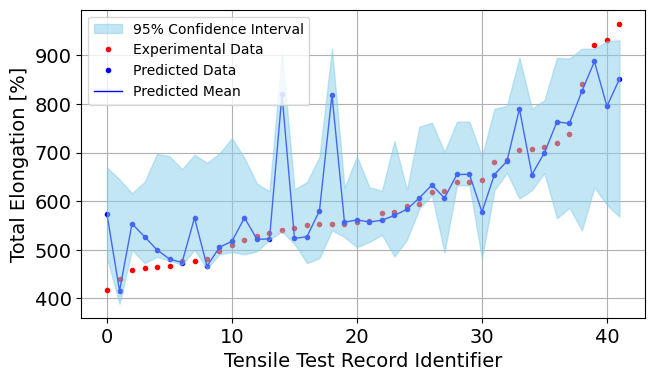

********************
q: 0.025 | pearsonr: 0.7805716675949596
q: 0.5 | pearsonr: 0.9364729603238545
q: 0.975 | pearsonr: 0.7929439368639906
Pearson CC: 0.9364729603238545
R2 score: 0.8690797451957496
RMSE: 48.385139057559115
MAE: 26.664035040900018
Coverage: 87.8048780487805
Interval Width: 191.39976238688234
Composite Metric: 0.6598427520866601


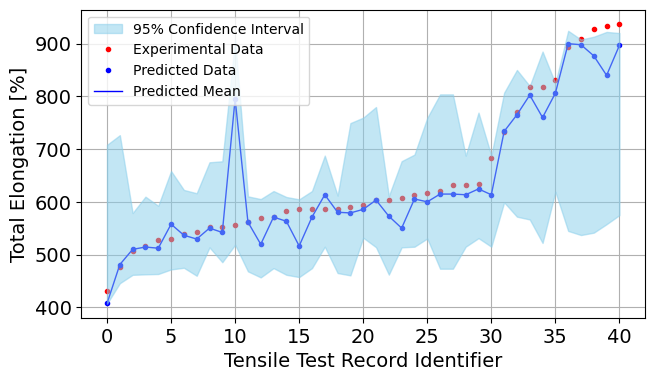

********************


In [19]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

quantiles = [0.025, 0.5, 0.975]

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
                X_train, X_test = features.iloc[tr], features.iloc[ts]
                scale = MinMaxScaler()
                X_train = scale.fit_transform(X_train)
                X_test = scale.transform(X_test)
                y_train, y_test = targets.iloc[tr], targets.iloc[ts]
                X_train, X_val, y_train, y_val = train_test_split(
                        X_train, y_train, test_size=0.1)

                for q in quantiles:
                        parameters = {'loss_function': 'Quantile:alpha={:0.2f}'.format(q),
                                'num_boost_round': 5000}
                        model = CatBoostRegressor(**parameters)
                        model.fit(X_train, np.log(y_train),
                                eval_set=[(X_val, np.log(y_val))],
                                early_stopping_rounds=20,
                                verbose=False)
                        y_pred = np.exp(model.predict(X_test))
                        print(f'q: {q} | pearsonr: {pearsonr(y_test, y_pred)[0]}')
                        if q==0.025:
                           y_low = y_pred
                        elif q==0.5:
                                y_median = y_pred
                        elif q==0.975:
                               y_high = y_pred
    
                # Plot the predictions
                iteration_list = [i for i in range(len(y_test))]

                PearsonCC[j, i] = pearsonr(np.squeeze(y_test), np.squeeze(y_median))[0]
                R2_score[j, i] = r2_score(y_test, y_median)
                RMSE[j, i] = np.sqrt(mean_squared_error(y_test, y_median))
                MAE[j, i] = np.mean(abs(y_median-np.array(y_test)))

                print(f'Pearson CC: {PearsonCC[j, i]}')
                print(f'R2 score: {R2_score[j, i]}')
                print(f'RMSE: {RMSE[j, i]}')
                print(f'MAE: {MAE[j, i]}')

                test_coverage[j, i] = coverage(y_test, y_low, y_high)
                print(f'Coverage: {test_coverage[j, i]}')

                # Prediction interval width
                median_interval_width[j, i] = np.median(y_high - y_low)
                print(f'Interval Width: {median_interval_width[j, i]}')

                # Composite metric that combines the coverage and the invers of interval width
                composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
                print(f'Composite Metric: {composite_metric[j, i]}')


                            # Plot the predictions
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    
                ## Uncertainty quantification plot
                ax[0].fill_between(iteration_list, y_low, y_high, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
                ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
                ax[0].plot(iteration_list, y_median, 'bo', markersize=3, label="Predicted Data")
                ax[0].plot(iteration_list, y_median, '-', linewidth=1, color="blue", label="Predicted Mean")
                ax[0].legend(fontsize=10, frameon=True, loc="upper left")
                ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
                ax[0].set_ylabel("Total Elongation [%]", fontsize=14)
                ax[0].tick_params(axis='both', which='major', labelsize=14)
                ax[0].grid(True, which='major', linestyle='-', linewidth='0.8')


                fig.delaxes(ax[1])
                plt.show()
                print(20*'*')

In [20]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.933232,0.868582,55.702425,32.166646,85.714286
1,0.971392,0.938092,29.471508,20.429535,90.476190
2,0.907729,0.820094,60.437165,34.546802,88.095238
3,0.821630,0.653253,77.379324,45.343012,78.571429
4,0.936473,0.869080,48.385139,26.664035,87.804878


In [21]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.914091,0.050478,0.82982,0.095956,54.275112,15.644317,31.830006,8.327708,86.132404,4.07091


In [22]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(), 'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,85.714286,319.125912,0.643641
1,90.476190,241.016207,0.679609
2,88.095238,264.837084,0.661658
3,78.571429,196.222340,0.590560
4,87.804878,191.399762,0.659843


In [23]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,86.132404,4.07091,242.520261,47.171032,0.647062,0.030463
